In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import itertools
import scipy.signal as sig
import shutil
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from collections import OrderedDict
import scipy.stats as scs
import scipy.signal as sig

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, squeezenet1_0
from torch.utils import data as torchdata

from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from src.data.dataset import ImageFilesDataset, ImageFilesDatasetBox, get_bounding_box_dataset
import src.utils as utils
from src.vision.transforms import *
from src.data.clip import *
import logging
from logging.config import fileConfig

from src.models.models import *
from src.features.court_bounding_boxes import *
from src.features.extract_court_keypoints import *

fileConfig('../logging_config.ini')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for x1, y1, x2, y2 in lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

In [5]:
frame_path = Path("../data/processed/frames/")

video_frames = list(frame_path.iterdir())
clip_path = Path("../data/interim/clips/")

videos = [Video.from_dir(v) for v in video_frames]
videos

[anderson_federer_wim_18,
 coric_federer_halle_18,
 djokovic_anderson_wim_18,
 djokovic_federer_aus_16,
 djokovic_murray_french_16,
 federer_cilic_aus_18,
 federer_nadal_iw_17,
 haase_zverev_cincinnati_18,
 nadal_marterer_french_18,
 nadal_tsitsipas_barcelona_18,
 osaka_halep_rome_18,
 zverev_isner_miami_18]

In [30]:
im_size = 256
# features = np.load(Path("../data/interim/featurized_frames/") / (video.name + ".npy"))
match = videos[4]
match_name = match.name
ds = ImageFilesDataset(match.frames)
tfms = transforms.Compose([
    transforms.ToTensor(),
    TorchImageToNumpy()])
ds = ds.with_transforms(tfms)
match_metas = utils.get_match_metadata(Path("../src/match_meta.txt"))
# loader = torchdata.DataLoader(ds.with_transforms(tfms), batch_size=16, num_workers=4)

In [31]:
meta_file = "../src/match_meta.json"
with open(meta_file, 'r') as f:
    match_metas = json.load(f)

In [38]:
_match_meta = {'court_crop': {'x': [40, 580, 450, 170], 'y': [310, 310, 75, 75]},
             'min_vert_line_dist': 150,
             'min_horiz_line_dist': 150,
             'min_sideline_slope': 1.5,
             'max_baseline_offset': 100,
             'min_vert_slope': 1.3,
             'max_horiz_slope': 0.01,
              'dilate_edges': True}

In [39]:
if match_name not in match_metas:
    match_meta = _match_meta
else:
    print("found it")
    match_meta = match_metas[match_name]
    print('court_crop' in match_meta)
    match_meta.update(_match_meta)

found it
True


In [40]:
match_meta

{'box': [33, 314, 145, 27],
 'min_score_text_width': 5,
 'min_score_text_height': 5,
 'invert': True,
 'score_thresh_low': 100,
 'min_score_width': 80,
 'court_crop': {'x': [40, 580, 450, 170], 'y': [310, 310, 75, 75]},
 'min_vert_line_dist': 150,
 'min_horiz_line_dist': 150,
 'min_sideline_slope': 1.5,
 'max_baseline_offset': 100,
 'min_vert_slope': 1.3,
 'max_horiz_slope': 0.01,
 'dilate_edges': True}

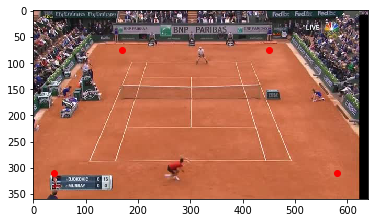

In [41]:
idx = 615
im = cv2.imread(str(ds.files[idx]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
pts = np.array([match_meta['court_crop']['x'], match_meta['court_crop']['y']], dtype=np.int32).T
plt.scatter(pts[:, 0], pts[:, 1], c='r')

In [42]:
img = im.astype(np.uint8)
im_h, im_w = img.shape[:2]
masked_image = mask_image(img, pts, dilate=match_meta['dilate_edges'])

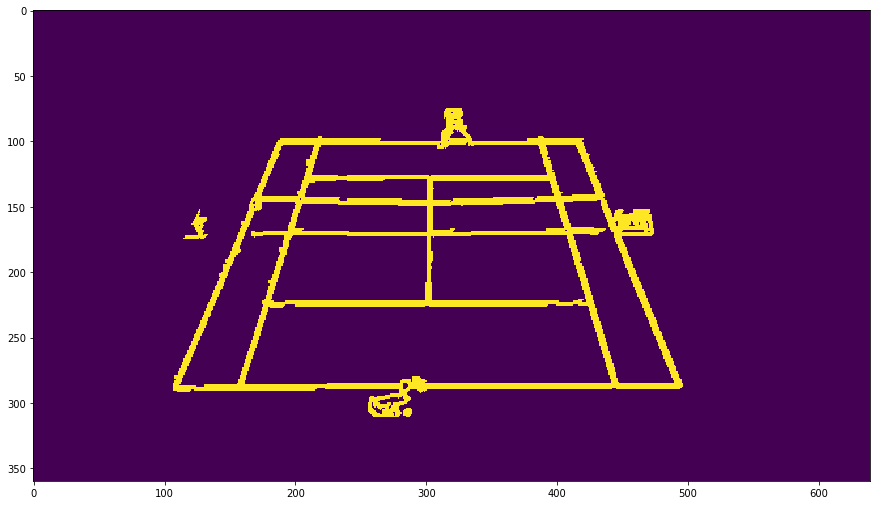

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.imshow(masked_image.astype(np.uint8))

(15, 4) (13, 4)


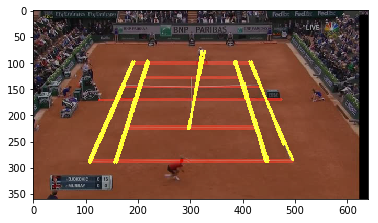

In [44]:
lines = cv2.HoughLinesP(
    masked_image.astype(np.uint8),
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
lines = lines.squeeze()

horizontal_lines, vertical_lines = get_lines(lines, min_horiz_len=match_meta['min_horiz_line_dist'],
                                             min_vert_len=match_meta['min_vert_line_dist'],
                                            min_vert_slope=match_meta['min_vert_slope'])
print(vertical_lines.shape, horizontal_lines.shape)
line_image = draw_lines(img, horizontal_lines)
line_image = draw_lines(line_image, vertical_lines, color=[255, 255, 0])
plt.imshow(line_image)

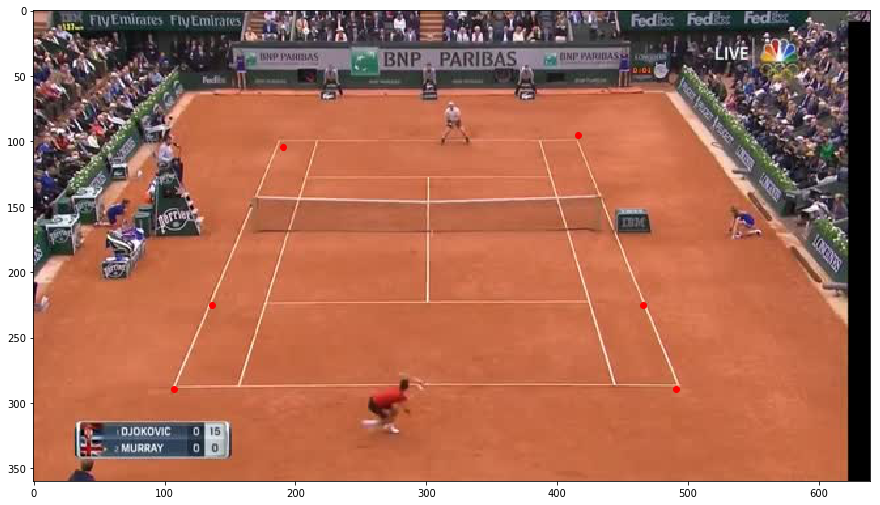

In [45]:
y_base, y_serve = get_baseline_vertical(horizontal_lines, min_separation=30)
right_sideline, left_sideline = get_sidelines(vertical_lines)
x1, x2, x3, x4 = get_keypoints_horizontal(y_base, y_serve, right_sideline, left_sideline)
y1, y2, y3, y4 = y_base, y_base, y_serve, y_serve
x6, y6 = get_top_corner(x1, y1, x4, y4, x2)
x5, y5 = get_top_corner(x2, y2, x3, y3, x1)
valid_box = utils.validate_court_box((x1, y1), (x2, y2), (x5, y5), (x6, y6),
                                im_h=im_h, im_w=im_w)
keypoints = np.array([[x1, x2, x3, x4, x5, x6], [y1, y2, y3, y4, y5, y6]]).T
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.imshow(img)
ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r')

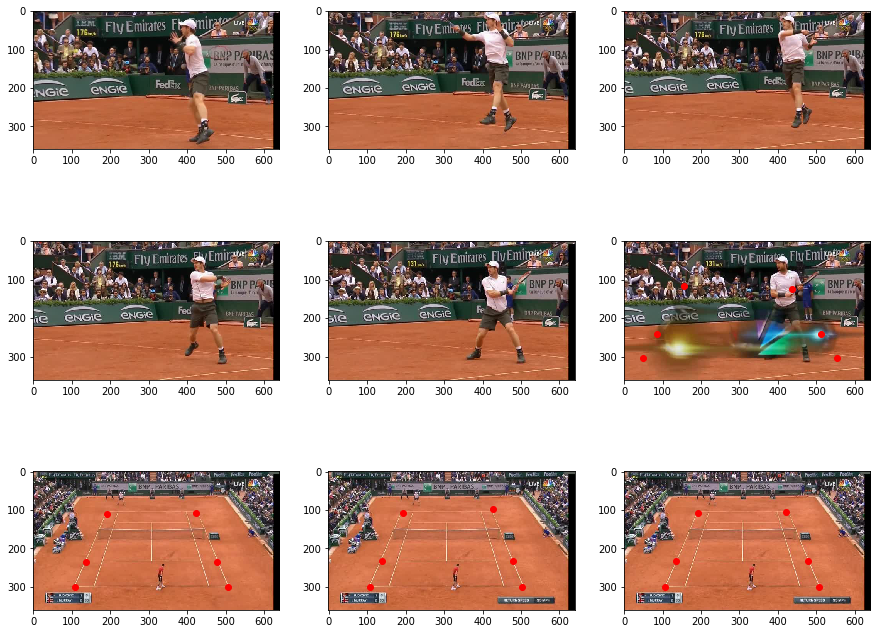

In [50]:
fig, axs = plt.subplots(3,3, figsize=(15, 12))
idx = 1299
for i, ax in enumerate(np.array(axs).reshape(-1)):
    _im, _ = ds[idx + i]
    ax.imshow(_im)
    img = (_im * 255)
    img = img.astype(np.uint8)
    masked_image = mask_image(img, pts, dilate=match_meta['dilate_edges'])
    lines = cv2.HoughLinesP(
        masked_image.astype(np.uint8),
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
    lines = lines[:, 0, :]
    

    horizontal_lines, vertical_lines = get_lines(lines, min_horiz_len=match_meta['min_horiz_line_dist'],
                                             min_vert_len=match_meta['min_vert_line_dist'],
                                            min_vert_slope=match_meta['min_vert_slope'])
    y_base, y_serve = get_baseline_vertical(horizontal_lines, min_separation=30)
    if y_base == 0 or y_serve == 0:
        continue
    if im_h - y_base > match_meta['max_baseline_offset']:
        continue
    right_sideline, left_sideline = get_sidelines(vertical_lines)
    if not right_sideline.any() or not left_sideline.any():
        continue
    right_sideline, left_sideline = get_sidelines(vertical_lines)
    x1, x2, x3, x4 = get_keypoints_horizontal(y_base, y_serve, right_sideline, left_sideline)
    y1, y2, y3, y4 = y_base, y_base, y_serve, y_serve
    x6, y6 = get_top_corner(x1, y1, x4, y4, x2)
    x5, y5 = get_top_corner(x2, y2, x3, y3, x1)
    valid_box = utils.validate_court_box((x1, y1), (x2, y2), (x5, y5), (x6, y6),
                                    im_h=im_h, im_w=im_w)
    keypoints = np.array([[x1, x2, x3, x4, x5, x6], [y1, y2, y3, y4, y5, y6]]).T
    
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r')

In [51]:
match_metas[match_name] = match_meta

In [52]:
with open(meta_file, 'w') as f:
    json.dump(match_metas, f)